In [3]:
import pandas as pd
import numpy as np
import random
import copy

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [4]:
def cross_validate(model, X, y, n_folds):
    score = {'fit_score': [], 'test_score': []}
    
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=10)
    
    for train, test in kf.split(X, y):
        X_train, y_train = X[train, :], y[train]
        X_test, y_test = X[test, :], y[test]
        
        model.fit(X_train, y_train)
        
        pred_train_y = model.predict(X_train)
        
        pred_test_y = model.predict(X_test)
        
        score['fit_score'].append(accuracy_score(y_train, pred_train_y))
        score['test_score'].append(accuracy_score(y_test, pred_test_y))
    return score

In [5]:
data = pd.read_csv('sonar.all-data.csv', delimiter=',', header=None)

train, test = train_test_split(data.get_values(), test_size=0.2)

model = SVC(C=10.0, gamma=0.01)

score = cross_validate(model, train[:,:-1], train[:,-1], n_folds=10)

In [6]:
"Mean accuracy on fit: {} / Mean accuracy on test {}".format(np.mean(score['fit_score']), np.mean(score['test_score']))

'Mean accuracy on fit: 0.8118637765282062 / Mean accuracy on test 0.741421568627451'

In [7]:
svm_params = {'C': 10.0, 'gamma': 0.01}

def perturbacao(current):
    new_value = current.copy()
    
    while True:
        param_to_change = random.choice(['C', 'gamma'])

        p = np.random.random()

        direction = random.choice([-1, 1])
    
        print(param_to_change, p, direction)
    
        if (p < 0.8):
            new_value[param_to_change] = current[param_to_change] + ((np.random.uniform(0, current[param_to_change] * 0.3)) * direction)
        else:
            new_value[param_to_change] = current[param_to_change] + (np.random.uniform(0, current[param_to_change] * 5.0))
            
        if (new_value['C'] >= 1 and new_value['gamma'] > 0):
            break
    
    return new_value
    
perturbacao(svm_params)

C 0.23132638631223434 -1


{'C': 9.806185783618936, 'gamma': 0.01}

In [22]:
params_range = {'C':[1.,1000.], 'gamma':[0.01,0.1]}
params_var   = {'C':[1.,1000.], 'gamma':[0.01,1.1]}

def generate_neighbours(current, n):
    """
    Geração da vizinhança para uma solução.
    
    Parâmetros
        current: solução atual
        n......: número de vizinhos que serão gerados
    """
    neighbourhood = []
    params = ['C','gamma']
    operations = ['+','-']
    
    for i in range(n):
        
        new_par = current.copy()
        
        while True:
        
            for p in params:

                if np.random.randint(0,2) == 1:

                    while True:
                        op = random.choice(operations)
                        factor = np.random.uniform(low=params_var[p][0], high=params_var[p][1])
                        #factor = round(np.random.uniform(low=1., high=10.), 1)

                        if op == '-':
                            factor = new_par[p] + (factor * -1)#(np.log2(factor) * -1)

                        new_value = new_par[p] + factor

                        if new_value >= params_range[p][0] and new_value <= params_range[p][1]:
                            new_par[p] = np.round(new_value, 2)
                            break

            if new_par not in neighbourhood:
                neighbourhood.append(new_par)
                break
        
    return neighbourhood

In [9]:
def find_neighbour(X, y, neighborhood):
    """
    Encontra o melhor entre a vizinhança, baseado na acurácia
    
    Parâmetros
        X...........: Valores do dataset
        y...........: Labels do dataset
        neighborhood: vizinhança que será avaliada
    """
    folds = 10
    
    best_neighbour = None
    
    for neighbor in neighborhood:
        model = SVC(C = neighbor['C'], gamma=neighbor['gamma'])
        neighbor_score = cross_validate(model, X, y, n_folds=folds)
        
        if best_neighbour == None or best_neighbour_score < np.mean(neighbor_score['test_score']):
            best_neighbour = neighbor
            best_neighbour_score = np.mean(neighbor_score['test_score'])

    return best_neighbour, best_neighbour_score

In [10]:
def update_tabu_list(tabu_list, size):
    if len(tabu_list) > size:
        tabu_list.pop(0)

def check_tabu_list(solution, tabu_list):
    if solution not in tabu_list:
        tabu_list.append(solution)
        update_tabu_list(tabu_list, tabu_list_size)
        print('Atualizou Tabu List')
        return True
    
    return False

In [11]:
from tqdm import tqdm_notebook as tqdm

In [26]:
current = {'C': 1.0, 'gamma': 0.01}

model = SVC(C = current['C'], gamma=current['gamma'])

current_score = cross_validate(model, train[:,:-1], train[:,-1], n_folds=10)

print("Current params {}".format(current))

print("FIT >> Mean accuracy train set {} / Mean accuracy test set {}".format(np.mean(current_score['fit_score']), np.mean(current_score['test_score'])))

predicted = model.predict(test[:,:-1])

accuracy = accuracy_score(test[:,-1], predicted)

print("TEST >> Accuracy test set {}".format(accuracy))


best_solution = current
best_score = np.mean(current_score['test_score'])

iterator = 30
tabu_list_size = 3
tabu_list = list()

with tqdm(total=iterator) as pbar:
    
    for i in range(0,iterator):
        neighbourhood = generate_neighbours(current,25)
        
        best_neighbour, best_neighbour_score = find_neighbour(train[:,:-1], train[:,-1], neighbourhood)

        if best_neighbour_score > best_score and check_tabu_list(best_neighbour, tabu_list):
            current = best_neighbour
            best_solution = best_neighbour
            best_score = best_neighbour_score
        
        current = best_neighbour
        
        print(tabu_list)

        pbar.update(1)

model = SVC(C = best_solution['C'], gamma=best_solution['gamma'])

current_score = cross_validate(model, train[:,:-1], train[:,-1], n_folds=10)

print("Current params {}".format(current))

print("FIT >> Mean accuracy train set {} / Mean accuracy test set {}".format(np.mean(current_score['fit_score']), np.mean(current_score['test_score'])))

predicted = model.predict(test[:,:-1])

accuracy = accuracy_score(test[:,-1], predicted)

print("TEST >> Accuracy test set {}".format(accuracy))

Current params {'C': 1.0, 'gamma': 0.01}
FIT >> Mean accuracy train set 0.5615887901324144 / Mean accuracy test set 0.5599264705882353
TEST >> Accuracy test set 0.6666666666666666


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

Atualizou Tabu List
[{'C': 158.45, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}]
Atualizou Tabu List
[{'C': 158.45, 'gamma': 0.05}, {'C': 108.03, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}, {'C': 108.03, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}, {'C': 108.03, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}, {'C': 108.03, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}, {'C': 108.03, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}, {'C': 108.03, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}, {'C': 108.03, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}, {'C': 108.03, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}, {'C': 108.03, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}, {'C': 108.03, 'gamma': 0.05}]
[{'C': 158.45, 'gamma': 0.05}, {'C': 108.03, 'gamma': 0.05}]
[{'C': 158

In [300]:
import matplotlib.pyplot as plt

In [488]:
x = np.log2(np.arange(1.,10., 0.1))

In [489]:
plt.plot(x)

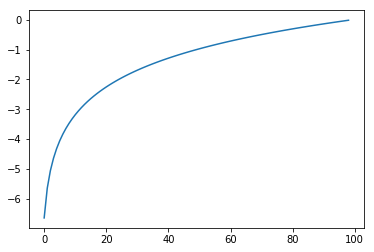

In [490]:
x = np.log2(np.arange(0.01,1., 0.01))
plt.plot(x)

In [431]:
#Teste com GridSearch
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [434]:
param_sel = svc_param_selection(train[:,:-1], train[:,-1], 10)

param_sel

{'C': 10, 'gamma': 1}

In [495]:
#model = SVC(C = param_sel['C'], gamma=param_sel['gamma'])
model = SVC(C = 157.74, gamma=0.08)

current_score = cross_validate(model, train[:,:-1], train[:,-1], n_folds=10)

print("Current params {}".format(param_sel))

print("FIT >> Mean accuracy train set {} / Mean accuracy test set {}".format(np.mean(current_score['fit_score']), np.mean(current_score['test_score'])))

predicted = model.predict(test[:,:-1])

accuracy = accuracy_score(test[:,-1], predicted)

print("TEST >> Accuracy test set {}".format(accuracy))

Current params {'C': 10, 'gamma': 1}
FIT >> Mean accuracy train set 0.997324384787472 / Mean accuracy test set 0.8316176470588236
TEST >> Accuracy test set 0.8571428571428571
